<a href="https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Physics_Informed_Neural_Networks_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics Informed Neural Networks using PINNModel

### Physics Informed Neural Networks

PINNs was introduced by Maziar Raissi et. al in their paper [Physics Informed Deep Learning (Part I): Data-driven
Solutions of Nonlinear Partial Differential Equations](https://arxiv.org/abs/1711.10561) which are used for solving supervised learning tasks and also follow an underlying differential equation derived from understanding the Physics. In more simple terms, we try solving a differential equation with a neural network and using the differential equation as the regulariser in the loss function.

<br>

---

Here is an illustration of PINNs using a simple differential equation


$\quad \quad \quad \frac{df}{dt} = f(u, t), \quad  $ where initial condition is $\ \ u(t=0) = u_0$

<br>


We approximate function $u(t)$ using a Neural Network as $NN(t)$ and apply the following loss function - 

<br>


  Initial Loss: $\quad  L_0 = (NN(t=0) - u_0)^2$

  Regulariser Loss:= $\quad L_r = | \frac{d NN (t) }{d t} - f(NN(t), t) |$

<br>


And we minimise the $Total Loss$ using Backpropagation-

<br>


  Total Loss = Initial Loss + Regulariser Loss

<br>


Here is a technical definition of PINNs taken from the author's official blog-

  $\quad \quad u_t + \mathcal{N}[u] = 0,\ x \in \Omega, \ t\in[0,T],$

<br>


where $\ u(t,x) \ $ denotes the latent (hidden) solution, $\ N[⋅] \ $ is a nonlinear differential operator, and $Ω$ is a subset of $\ \mathbb{R}^D \ $ , and proceed by approximating $u(t,x)$ by a deep neural network. We define $\ f(t,x) \ $ to be given by

<br>
 
  $\quad \quad f := u_t + \mathcal{N}[u],$

<br>

This assumption results in a physics informed neural network $ \ f(t,x) \ $. This network can be derived by the calculus on computational graphs: Backpropagation.

<br>

---

Useful Resources to learn more about PINNs


- [Maziar Raissi et. al. official blog on PINNs](https://maziarraissi.github.io/PINNs/)
- [Chris Rackauckas's lecture on PINNs lecture 3](https://github.com/mitmath/18337#lecture-3-introduction-to-scientific-machine-learning-through-physics-informed-neural-networks): these lectures are in Julia programming language but still are a great source of learning.

### Setup


In [1]:
!pip install --pre deepchem -q

In [2]:
import torch
import numpy as np
import deepchem as dc
from deepchem.models.torch_models.pinns_model import PINNModel
import matplotlib.pyplot as plt

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
/home/spellsharp/anaconda3/envs/deepchem/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-15 14:37:10.286171: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-15 14:37:10.299227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742029630.314826  332659 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin c

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow.keras'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/spellsharp/AI/deepchem_work/deepchem/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'


### Burgers Equation

Burgers' equation is a partial differential equation that was originally proposed as a simplified model of turbulence as exhibited by the full-fledged Navier-Stokes equations. It is a nonlinear equation for which exact solutions are known and is therefore important as a benchmark problem for numerical methods. [More Reference](https://www.azimuthproject.org/azimuth/show/Burgers%27+equation)

<br>

Here is the differential Equation we are trying to solve

$$u_t + u u_x - (0.01/\pi) u_{xx} = 0,\ \ \ x \in [-1,1],\ \ \ t \in [0,1]$$

<br>

Here are the initial conditions

$$u(x, 0) = -\sin(\pi x),$$

$$u(-1, t) = u(1, t) = 0.0$$

<br>

Now let us define:

$$f := u_t + u u_x - (0.01/\pi) u_{xx},$$

and we approximate $u(x, t)$ using Neural Network as $NN(\theta, x, t)$ where $\theta$ are the weights of neural networks 

<br>

---

</br>
Now here are the three main data points that will be used for training our Neural Network to approximate $u(x,t)$


1. We will train points lying between $x \in [-1,1]$ and $t=0$ to follow as part of the L2 Loss

   $$\min_\theta (NN(\theta, x, t) + \sin(\pi x))^2$$

<br>

2. We will train points lying between $t \in [0,1]$ and $x= \pm1$ as part of the L2 Loss

   $$\min_\theta (NN(\theta, x, t) + \sin(\pi x))^2$$

<br>

3. We will train points lying between $x \in [-1,1],\ \ \ t \in [0,1]$ as part of the regulariser loss

   $$f(\theta, x, t):= \frac{\partial NN(\theta, x, t)}{\partial t} + NN(\theta, x, t)\frac{\partial NN(\theta, x, t)}{\partial x} - (0.01/\pi)\frac{\partial^2 NN(\theta, x, t)}{\partial^2 x}$$

   $$\min_\theta f(\theta, x, t)$$

</br>

In this tutorial, we will be combining data conditions 1 and 2 under the same L2 Loss

In [3]:
def generate_collocation_points(n_x=50, n_t=50, x_min=-1.0, x_max=1.0, t_min=0.0, t_max=1.0):
    x = np.linspace(x_min, x_max, n_x)
    t = np.linspace(t_min, t_max, n_t)
    X, T = np.meshgrid(x, t)
    X_interior = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    # Dummy labels for collocation points (not used in the PDE residual loss)
    y_dummy = np.zeros((X_interior.shape[0], 1))
    return torch.tensor(X_interior, dtype=torch.float32), X_interior, y_dummy

X_interior_tensor, X_interior, y_values = generate_collocation_points(n_x=100, n_t=100)

### Explanation of the solution

We will be using Deepchem's `PINNModel` class to solve Burger's Equation which is based out of `PyTorch` library. We will approximate $u(x, t)$ using a Neural Network represented as $NN(\theta, x, t)$

As per the requirements of the PyTorch PINN model, we need to define how to compute the gradients and losses for our differential equation.

For our purpose, we have two variables $(x, t)$ and we need to calculate gradients with respect to these inputs. For carrying out this process we will be using PyTorch's autograd functionality:

1. `torch.autograd.grad` - This computes gradients of outputs with respect to inputs
2. `requires_grad=True` - This marks tensors to track operations for automatic differentiation

We need to compute two losses for solving our differential equation:

1. Boundary/Initial Condition Loss (L2 Loss)
2. Physics-Informed Regularizer Loss

This is slightly more complex as we need to compute:

$$f := \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} - (0.01/\pi)\frac{\partial^2 u}{\partial x^2}$$

The partial derivatives in PyTorch can be calculated using `torch.autograd.grad`

### Neural Network Architecture

The neural network consists of fully connected layers with tanh activation functions. It takes and $x$ as $t$ inputs and outputs $u(x,t)$:

In [4]:
class BurgersNet(torch.nn.Module):
    def __init__(self):
        super(BurgersNet, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )
    
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        return self.net(x)

In [5]:
def generate_boundary_data(x_min=-1.0, x_max=1.0, t_min=0.0, t_max=1.0, n_x=100):
    # Initial condition: u(x,0) = -sin(pi*x) for x in [-1,1]
    x_ic = np.linspace(x_min, x_max, n_x)
    t_ic = np.zeros_like(x_ic)
    X_ic = np.column_stack((x_ic, t_ic))
    u_ic = -np.sin(np.pi * x_ic)
    
    # Boundary conditions: u(-1,t)=0 and u(1,t)=0 for t in [0,1]
    t_bc = np.linspace(t_min, t_max, n_x)
    x_left = np.full_like(t_bc, x_min)
    x_right = np.full_like(t_bc, x_max)
    X_left = np.column_stack((x_left, t_bc))
    X_right = np.column_stack((x_right, t_bc))
    u_bc = np.zeros_like(t_bc)
    
    X_ic_tensor = torch.tensor(X_ic, dtype=torch.float32)
    u_ic_tensor = torch.tensor(u_ic.reshape(-1, 1), dtype=torch.float32)
    X_left_tensor = torch.tensor(X_left, dtype=torch.float32)
    X_right_tensor = torch.tensor(X_right, dtype=torch.float32)
    u_bc_tensor = torch.tensor(u_bc.reshape(-1, 1), dtype=torch.float32)
    
    boundary_data = {
        'dirichlet': {
            'points': torch.cat([X_ic_tensor, X_left_tensor, X_right_tensor], dim=0),
            'values': torch.cat([u_ic_tensor, u_bc_tensor, u_bc_tensor], dim=0)
        },
    }
    return boundary_data

boundary_data = generate_boundary_data(n_x=100)

In [6]:
def burgers_equation_residual(u, x):
    """
    Compute the residual for Burgers equation:
       u_t + u * u_x - nu * u_xx = 0
    where:
       - u_t is the time derivative,
       - u_x is the spatial derivative,
       - u_xx is the second spatial derivative,
       - nu is the viscosity coefficient (here, 0.01).
    """
    nu = 0.01/np.pi  # Viscosity coefficient
    x.requires_grad_(True)
    
    # First-order derivatives: gradients with respect to x and t
    grad_u = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_x = grad_u[:, 0:1]
    u_t = grad_u[:, 1:2]
    
    # Second-order derivative with respect to x
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0][:, 0:1]

    residual = u_t + u * u_x - nu * u_xx
    return residual

### Loss Function

The loss function is a combination of:
1. The residual loss for the differential equation.
2. The boundary and initial condition losses.

In [7]:
def custom_loss(outputs, labels, weights=None):
    # outputs is a tuple; the first element is the model output.
    outputs = outputs[0]
    inputs = model._inputs[0]
    
    # PDE residual loss on collocation (interior) points
    pde_loss = model._compute_pde_loss(inputs)
    
    # Boundary/Initial conditions loss (enforced via boundary_data)
    bc_loss = 0.0
    for key, value in model.boundary_data.items():
        if isinstance(value, dict):
            points = value.get('points')
            values = value.get('values')
            if points is not None and values is not None:
                pred = model.model(points)
                bc_loss += torch.mean((pred - values) ** 2)

    total_loss = pde_loss + 100 * bc_loss
    return total_loss

model = PINNModel(
    model=BurgersNet(),
    pde_fn=burgers_equation_residual,
    boundary_data=boundary_data,
    loss_fn=custom_loss,
)

In [8]:
dataset = dc.data.NumpyDataset(X=X_interior, y=y_values)
model.fit(dataset, nb_epoch=1000)

0.0026190561056137086

We can verify that the model's predictions satisfy the initial conditions by simply obtaining the mean squared error of the prediction with respect to the labels for the initial condition points which are the first 100 data points in the boundary data.

In [11]:
X_ic = boundary_data['dirichlet']['points'][:50]  # take first 50 initial condition points
u_ic_pred = model.model(X_ic)

# True initial values: u(x, 0) = -sin(pi * x)
x_ic = X_ic[:, 0].detach().numpy()
u_ic_true = -np.sin(np.pi * x_ic)

mse_ic = np.mean((u_ic_pred.detach().numpy().flatten() - u_ic_true) ** 2)
print("Initial Condition MSE:", mse_ic)

Initial Condition MSE: 3.209786e-05


To verify that our model obeys the physics rules, we can obtain the residuals of the partial differential equation and check if the values are low or not. The close the residual is to zero, the better.

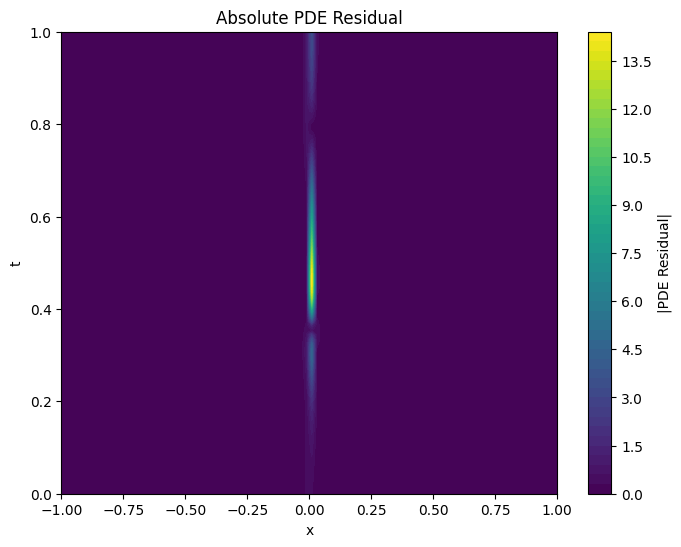

In [12]:
def compute_pde_residual(model, x_points, t_points):
    x = np.linspace(-1, 1, x_points)
    t = np.linspace(0, 1, t_points)
    X, T = np.meshgrid(x, t)
    X_eval = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32, requires_grad=True)
    
    u_pred = model.model(X_eval_tensor)
    
    residual = burgers_equation_residual(u_pred, X_eval_tensor)
    return x, t, residual.detach().numpy().reshape(t_points, x_points)


x_vals, t_vals, residual_field = compute_pde_residual(model, 100, 100)

plt.figure(figsize=(8,6))
plt.contourf(x_vals, t_vals, np.abs(residual_field), levels=50, cmap='viridis')
plt.colorbar(label='|PDE Residual|')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute PDE Residual')
plt.show()


### Visualization of Results

We predict the solution using the trained PINN model and visualize the results.

In [ ]:
def predict_solution(model, x_points, t_points):
    x = np.linspace(-1, 1, x_points)
    t = np.linspace(0, 1, t_points)
    X, T = np.meshgrid(x, t)
    X_pred = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    X_pred_tensor = torch.tensor(X_pred, dtype=torch.float32)
    
    with torch.no_grad():
        u_pred = model.model(X_pred_tensor).numpy()
    
    u_pred = u_pred.reshape(t_points, x_points)
    return x, t, u_pred

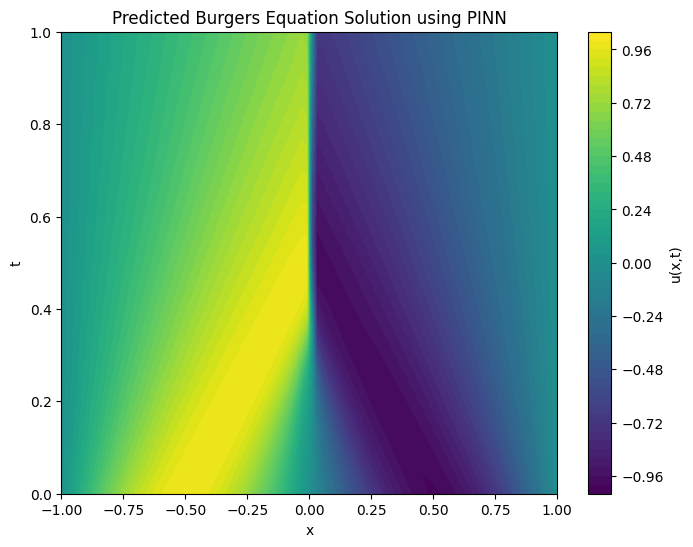

In [ ]:
x_vals, t_vals, u_pred = predict_solution(model, 100, 100)

plt.figure(figsize=(8, 6))
plt.contourf(x_vals, t_vals, u_pred, levels=50, cmap='viridis')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted Burgers Equation Solution using PINN')
plt.show()

### Understanding the Predicted Solution for Burgers' Equation


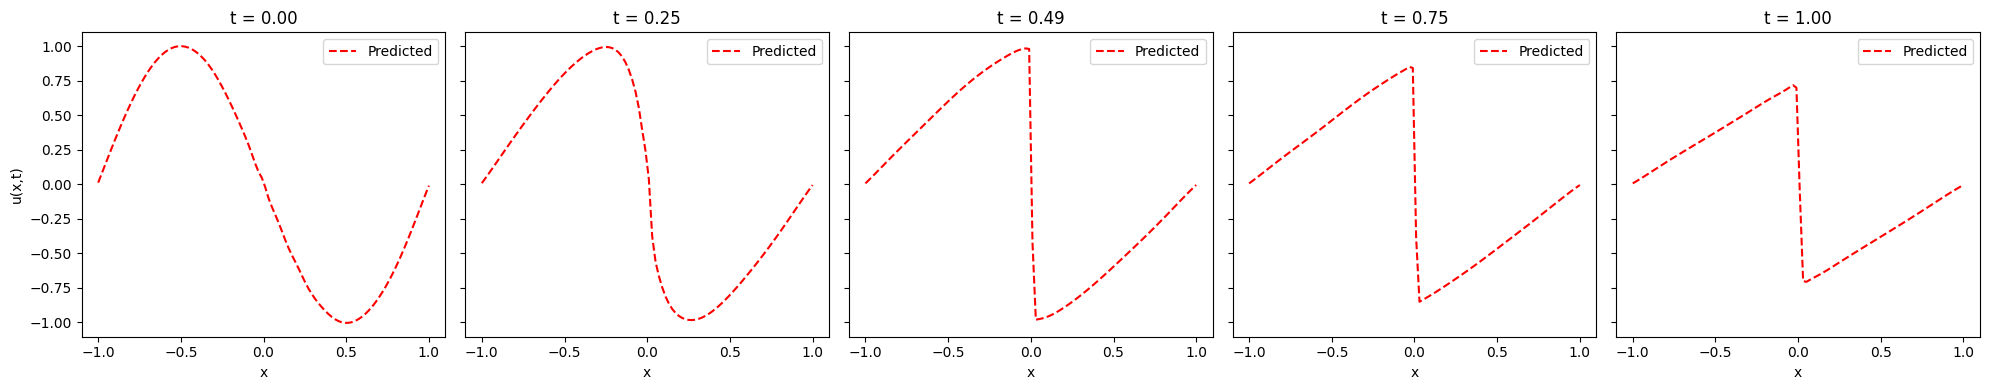

In [13]:
x_mod, t_mod, u_pred_mod = predict_solution(model, 100, 100)

selected_t_values = [0.0, 0.25, 0.5, 0.75, 1.0]

fig, axs = plt.subplots(1, len(selected_t_values), figsize=(20, 4), sharey=True)

for i, t_val in enumerate(selected_t_values):
    idx = np.argmin(np.abs(np.array(t_mod) - t_val))
    axs[i].plot(x_mod, u_pred_mod[idx, :], 'r--', label='Predicted')
    axs[i].set_title(f"t = {t_mod[idx]:.2f}")
    axs[i].set_xlabel('x')
    if i == 0:
        axs[i].set_ylabel('u(x,t)')
    axs[i].legend()

plt.tight_layout()
plt.show()

The plotted results confirm that the neural network is solving Burgers' equation by demonstrating key expected behaviors. Initially, at $t = 0$, the solution follows the given initial condition:  

$$ u(x, 0) = -\sin(\pi x) $$  

As time progresses, the wave steepens due to the nonlinear term $u u_x$, forming a characteristic shock structure visible in the plots at $t = 0.49, 0.75,$ and $1.00$.  

This behavior aligns with the well-known solution of Burgers' equation, where the wavefront sharpens over time before forming a shock. Additionally, the boundary conditions:  

$$ u(-1, t) = u(1, t) = 0 $$  

appear to be satisfied, further validating the correctness of the predicted solution.